In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import timm

from torch.utils.data import DataLoader

In [2]:
# 設置設備（GPU如果可用，否則使用CPU）
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 數據預處理和加載
transform = transforms.Compose([
    transforms.ToTensor()
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# 定義CNN模型
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.embedding = nn.Embedding(256, 32)
        self.conv1 = nn.Conv3d(3, 32, 3)
        self.pool = nn.MaxPool3d(2, 2)
        self.conv2 = nn.Conv3d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 6 * 6 * 6, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.embedding(x)
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = x.view(-1, 64 * 6 * 6 * 6)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    
test = Net()
test_input = torch.randint(0, 256, (4, 3, 32, 32))
print(f"Input shape: {test_input.shape}")
test_output = test(test_input)
print(f"Output shape: {test_output.shape}") # should be (batch_size, 10)

Input shape: torch.Size([4, 3, 32, 32])
Output shape: torch.Size([4, 10])


In [4]:
# net = Net().to(device)
net = timm.create_model('resnet18', num_classes=10).to(device)

# 定義損失函數和優化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=0.001)

# 訓練模型
for epoch in range(2):  # 遍歷數據集兩次
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # inputs = inputs.int()
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:    # 每2000個mini-batches打印一次
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

# 在測試集上評估模型
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # images = images.int()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')

[1,  2000] loss: 2.106
[1,  4000] loss: 1.874
[1,  6000] loss: 1.762
[1,  8000] loss: 1.673
[1, 10000] loss: 1.585
[1, 12000] loss: 1.533
[2,  2000] loss: 1.450
[2,  4000] loss: 1.387
[2,  6000] loss: 1.315
[2,  8000] loss: 1.314
[2, 10000] loss: 1.319
[2, 12000] loss: 1.220
Finished Training
Accuracy of the network on the 10000 test images: 57.36%


In [5]:
# Accuracy of the network on the 10000 test images: 12.69% Embedding + Conv3d
# Accuracy of the network on the 10000 test images: 57.36% ResNet18

```py
# 定義CNN模型
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.embedding = nn.Embedding(256, 32)
        self.conv1 = nn.Conv3d(3, 32, 3)
        self.pool = nn.MaxPool3d(2, 2)
        self.conv2 = nn.Conv3d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 6 * 6 * 6, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.embedding(x)
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = x.view(-1, 64 * 6 * 6 * 6)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
```

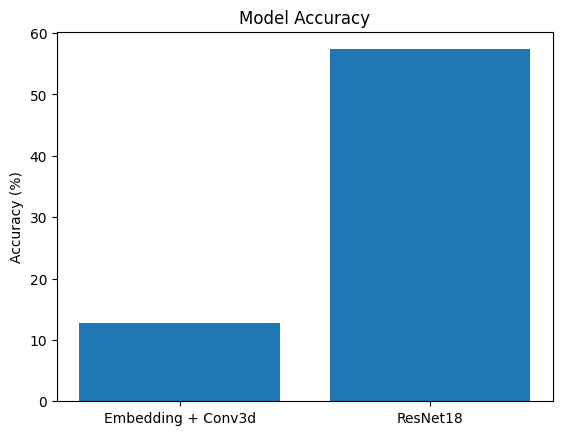

In [7]:
data_accuracy = {
    "Embedding + Conv3d": 12.69,
    "ResNet18": 57.36
}

import matplotlib.pyplot as plt

plt.bar(data_accuracy.keys(), data_accuracy.values())
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy')
plt.show()

由此可見，embedding + conv3d 不是個好的組合。